In [ ]:
!pip install -q diffusers transformers accelerate icecream

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 45.5 MB/s eta 0:00:00


In [ ]:
from icecream import ic
import tqdm

from PIL import Image

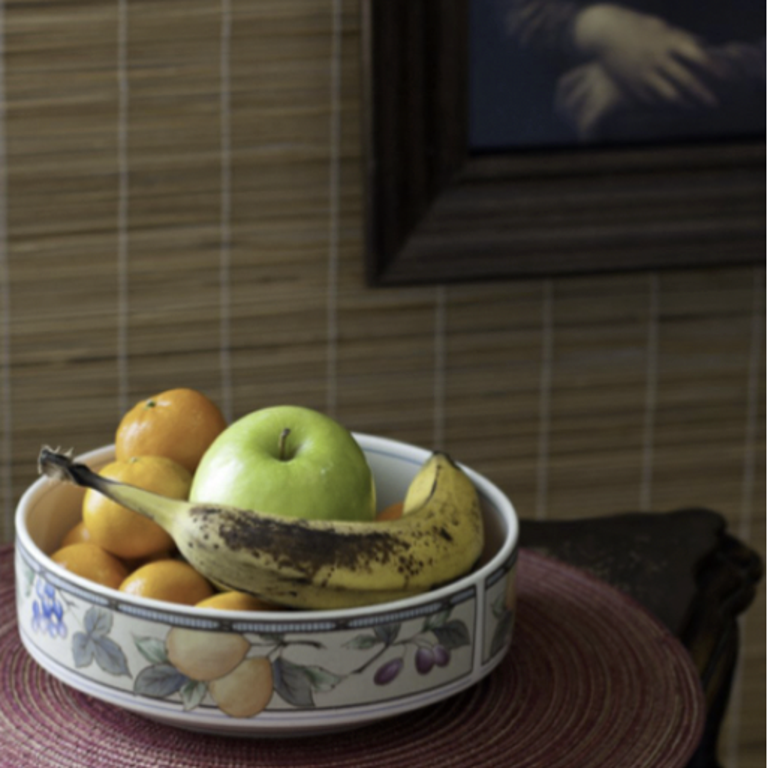

In [ ]:
from diffusers.utils import load_image, make_image_grid

img_url = "https://github.com/Xiang-cd/DiffEdit-stable-diffusion/raw/main/assets/origin.png"
raw_image = load_image(img_url).resize((768, 768))
raw_image

# Download Components

In [ ]:
# vae, decoding the latents
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel, DDIMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
import torch

# from diffusers import DDIMScheduler, DDIMInverseScheduler, StableDiffusionDiffEditPipeline
vae =  AutoencoderKL.from_pretrained("stabilityai/stable-diffusion-2-1", subfolder="vae")


# text encoder, generated via contrastive loss
tokenizer = CLIPTokenizer.from_pretrained("stabilityai/stable-diffusion-2-1", subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained("stabilityai/stable-diffusion-2-1", subfolder="text_encoder")


scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
# scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# unet: for generating the latents
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")
torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'

vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.w

vae/config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

# Generate Mask

## Prompt Embeds

In [ ]:
num_images_per_prompt = 10
torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'
source_prompt = "a bowl of fruits"
target_prompt = "a bowl of pears"
# source_prompt = "a dog in the park"
# target_prompt = "a rabbit in the park"

In [ ]:
import numpy as np

def img2latents(vae, image):
  image = torch.Tensor(np.array(image).astype(np.float32) / 255.0).unsqueeze(0).permute(0, 3, 1, 2)
  image = image.to(torch_device).type(vae.dtype)
  image = image*2 - 1
  with torch.no_grad():
    latents = vae.config.scaling_factor * vae.encode(image).latent_dist.sample()
  return latents

def latent2img(vae, latent):
  img_ = vae.decode(latent / vae.config.scaling_factor, return_dict=False)[0]
  img_ = (img_/2 + 0.5).clamp(0, 1).detach()*255
  img_ = img_.squeeze(0).permute(1, 2, 0).cpu().numpy().astype(np.uint8)
  return Image.fromarray(img_)

def plot_mask(masked_image):
  return Image.fromarray((masked_image.squeeze()*255).astype("uint8"), "L").resize((768, 768))

In [ ]:
original_latents = img2latents(vae, raw_image)
# latent2img(vae, original_latents)

In [ ]:
def encode_prompt(prompt, text_encoder, tokenizer, torch_device, num_images_per_prompt):
  text_inputs = tokenizer(
      prompt,
      padding="max_length",
      max_length=tokenizer.model_max_length,
      truncation=True,
      return_tensors="pt",
  )
  text_input_ids = text_inputs.input_ids
  prompt_embeds = text_encoder(text_input_ids.to(torch_device))
  return prompt_embeds[0].repeat(num_images_per_prompt, 1, 1)

def get_prompt_embeds(text_encoder, tokenizer, source_prompt, target_prompt, num_images_per_prompt):
  target_prompt_embeds = encode_prompt(
              target_prompt,
              text_encoder,
              tokenizer,
              torch_device,
              num_images_per_prompt=num_images_per_prompt
          )
  target_negative_prompt_embeds = encode_prompt(
              "",
              text_encoder,
              tokenizer,
              torch_device,
              num_images_per_prompt=num_images_per_prompt
          )
  source_prompt_embeds = encode_prompt(
              source_prompt,
              text_encoder,
              tokenizer,
              torch_device,
              num_images_per_prompt=num_images_per_prompt
          )
  source_negative_prompt_embeds = encode_prompt(
              "",
              text_encoder,
              tokenizer,
              torch_device,
              num_images_per_prompt=num_images_per_prompt
          )
  prompt_embeds = torch.cat(
      [source_negative_prompt_embeds, source_prompt_embeds, target_negative_prompt_embeds, target_prompt_embeds])
  return prompt_embeds

In [ ]:
num_inference_steps = 50
mask_encode_strength = 0.75


In [ ]:
def my_get_timesteps(scheduler, num_inference_steps, mask_encode_strength):
  scheduler.set_timesteps(num_inference_steps)
  t = int(num_inference_steps * mask_encode_strength)
  return scheduler.timesteps[num_inference_steps - t : ]

timesteps = my_get_timesteps(scheduler, num_inference_steps, mask_encode_strength)

encode_timestep = timesteps[0]

def add_noise_to_latents(original_latents, scheduler, encode_timestep, num_images_per_prompt, n=4):
  original_latents = torch.cat([original_latents]*num_images_per_prompt, dim=0)
  noise = torch.randn_like(original_latents)

  noisy_latents = scheduler.add_noise(original_latents, noise, encode_timestep)
  noisy_latents = torch.cat([noisy_latents] * n, dim=0)
  noisy_latents = scheduler.scale_model_input(noisy_latents, encode_timestep)

  ic(noisy_latents.size())
  return noisy_latents




In [ ]:
def my_generate_mask(prompt_embeds, noisy_latents, encode_timestep, unet):
  with torch.no_grad():
    noise_pred = unet(
                noisy_latents,
                encode_timestep,
                encoder_hidden_states=prompt_embeds,
            ).sample
  mask_thresholding_ratio=3.0
  ic(noise_pred.shape) # 40 x 4 x 96 x 96



  guidance_scale = 7.5

  noise_pred_neg_src, noise_pred_source, noise_pred_uncond, noise_pred_target = noise_pred.chunk(4)
  noise_pred_source = noise_pred_neg_src + guidance_scale * (noise_pred_source - noise_pred_neg_src)
  noise_pred_target = noise_pred_uncond + guidance_scale * (noise_pred_target - noise_pred_uncond)

  mask_guidance_map = (
            torch.abs(noise_pred_target - noise_pred_source)
            .reshape(1, num_images_per_prompt, *noise_pred_target.shape[-3:])
            .mean([1, 2])
        )
  ic(mask_guidance_map.shape) # 1 x 96 x 96
  clamp_magnitude = mask_guidance_map.mean() * mask_thresholding_ratio
  semantic_mask_image = mask_guidance_map.clamp(0, clamp_magnitude) / clamp_magnitude
  semantic_mask_image = torch.where(semantic_mask_image <= 0.5, 0, 1).type(torch.float16)
  return semantic_mask_image

In [ ]:
prompt_embeds = get_prompt_embeds(text_encoder, tokenizer, source_prompt, target_prompt, num_images_per_prompt)
noisy_latents = add_noise_to_latents(original_latents, scheduler, encode_timestep, num_images_per_prompt)
my_mask_image = my_generate_mask(prompt_embeds, noisy_latents, encode_timestep, unet)
plot_mask(my_mask_image.cpu().numpy())

ic| noisy_latents.size(): torch.Size([40, 4, 96, 96])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (3080x1024 and 768x320)

In [ ]:
prompt_embeds.shape

torch.Size([40, 77, 1024])

# Control set, delete this after confirming your mask generation works.

In [ ]:
# @title Give me a name {displaymode: "form"}

source_negative_prompt_embeds, source_prompt_embeds, target_negative_prompt_embeds, target_prompt_embeds = prompt_embeds.chunk(4)

mask_image_internal = pipeline.generate_mask(
    image=raw_image,
    output_type="np.array",
    target_prompt_embeds=target_prompt_embeds[0].unsqueeze(0),
    target_negative_prompt_embeds=target_negative_prompt_embeds[0].unsqueeze(0),
    source_prompt_embeds=source_prompt_embeds[0].unsqueeze(0),
    source_negative_prompt_embeds=source_negative_prompt_embeds[0].unsqueeze(0)
)

# plot_mask(mask_image_internal)
mask_image_internal = torch.Tensor(mask_image_internal).to(torch_device)



# Step 2: Encoding

In [ ]:
# timesteps are in dirty -> clean order (since that's the order in which we run diffusion)
# so the first latent will be the dirtiest image and the last will be cleanest
inverted_latents = torch.cat([add_noise_to_latents(original_latents, t, 1, n=1) for t in timesteps]).unsqueeze(0)

In [ ]:
pipeline.config

# Decoding with Mask Guidance

In [ ]:


guidance_scale = 7.5



source_negative_prompt_embeds, source_prompt_embeds, target_negative_prompt_embeds, target_prompt_embeds = prompt_embeds.chunk(4)
y_t = inverted_latents[0, 0]

encoder_hidden_states = torch.stack([target_prompt_embeds[0], source_prompt_embeds[0]])


for i, t in tqdm.tqdm(enumerate(timesteps), total=len(timesteps)):
    x_t = inverted_latents[0, i]

    y_t_hat = y_t * my_mask_image + x_t*(1-my_mask_image)
    y_t_hat = y_t_hat.squeeze(0).type(torch.float16)
    unet_input = torch.stack([y_t_hat for i in range(2)])

    unet_input = pipeline.scheduler.scale_model_input(unet_input, timestep=t).type(torch.float16)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = pipeline.unet(
            unet_input,
            t,
            encoder_hidden_states=encoder_hidden_states,
            cross_attention_kwargs={},
        ).sample


    # perform guidance
    noise_pred_target, noise_pred_source = noise_pred.chunk(2)
    noise_pred = noise_pred_source + guidance_scale * (noise_pred_target - noise_pred_source)

    # compute the previous noisy sample x_t -> x_t-1
    y_t = pipeline.scheduler.step(noise_pred, t, y_t_hat).prev_sample.squeeze(0)


In [ ]:
latent2img(pipeline, y_t)